## Introduction

Hello my name is Fadli Rizaldy, a data enthusiast since majoring physics in college. This project made for my personal exercise to practice machine learning workflow in real case. Thanks to Datacamp that provide this project and the dataset.

## 1. Credit card applications
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.</p>
<p><img src="https://wallpaperaccess.com/full/2666312.jpg" alt="Credit card being held in hand" width="500" height="600"></p>
<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>
<ul>
<li>First, we will start off by loading and viewing the dataset.</li>
<li>We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.</li>
<li>We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>
<p>First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.</p>

In [1]:
# Import Common Package
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('datasets/cc_approvals.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## 2. Inspecting the applications
<p>The output may appear a bit confusing at its first sight, but let's try to figure out the most important features of a credit card application. The features of this dataset have been anonymized to protect the privacy, but <a href="http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html">this blog</a> gives us a pretty good overview of the probable features. The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>
<p>As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

In [3]:
# print summary and statistics of the dataset
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB
None


,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [4]:
rows, columns = df.shape
f'This dataset has {rows} rows and {columns} columns'

'This dataset has 690 rows and 16 columns'

## 3. Splitting the dataset into train and test sets
<p>Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to preprocess the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then preprocess it.</p>
<p>Also, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. To get a better sense, we can measure their <a href="https://realpython.com/numpy-scipy-pandas-correlation-python/">statistical correlation</a> to the labels of the dataset. But this is out of scope for this project. We should drop them to design our machine learning model with the best set of features. In Data Science literature, this is often referred to as <em>feature selection</em>. </p>

In [5]:
df.drop([11, 13], axis=1, inplace=True)

# Split into train and test sets
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

## 4. Handling the missing values (part i)
<p>Now we've split our data, we can handle some of the issues we identified when inspecting the DataFrame, including:</p>
<ul>
<li>Our dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features 2, 7, 10 and 14 contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of in this task. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output of the second task.</li>
</ul>
<p>Now, let's temporarily replace these missing value question marks with NaN.</p>

In [6]:
arr = []
for i in df.columns:
    if '?' in df[i].unique():
        arr.append((f'col: {i}', True))
arr
# there's unknown value in the form of '?' in several columns

[('col: 0', True),
 ('col: 1', True),
 ('col: 3', True),
 ('col: 4', True),
 ('col: 5', True),
 ('col: 6', True)]

In [7]:
# Replace the '?'s with NaN in the train and test sets
df_train = df_train.replace('?', np.NaN)
df_test = df_test.replace('?', np.NaN)

## 5. Handling the missing values (part ii)
<p>We replaced all the question marks with NaNs. This is going to help us in the next missing value treatment that we are going to perform.</p>
<p>An important question that gets raised here is <em>why are we giving so much importance to missing values</em>? Can't they be just ignored? Ignoring missing values can affect the performance of a machine learning model heavily. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as Linear Discriminant Analysis (LDA). </p>
<p>So, to avoid this problem, we are going to impute the missing values with a strategy called mean imputation.</p>

In [8]:
# check missing value in train data and test data respectively
print(df_train.isna().sum())
print(df_test.isna().sum())

0     8
1     5
2     0
3     6
4     6
5     7
6     7
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64
0     4
1     7
2     0
3     0
4     0
5     2
6     2
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64


In [9]:
# Impute the missing values with mean imputation
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_train.mean(), inplace=True)

# we impute missing value in test data with mean of train data because we want to avoid "Data Leakage"

In [10]:
# Check again!
print(df_train.isna().sum())
print(df_test.isna().sum())

# there's nothing change, this is because we fillna to the numeric column. 

0     8
1     5
2     0
3     6
4     6
5     7
6     7
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64
0     4
1     7
2     0
3     0
4     0
5     2
6     2
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64


## 6. Handling the missing values (part iii)
<p>We have successfully taken care of the missing values present in the numeric columns. There are still some missing values to be imputed for columns 0, 1, 3, 4, 5, 6 and 13. All of these columns contain non-numeric data and this is why the mean imputation strategy would not work here. This needs a different treatment. </p>
<p>We are going to impute these missing values with the most frequent values as present in the respective columns. This is <a href="https://www.datacamp.com/community/tutorials/categorical-data">good practice</a> when it comes to imputing missing values for categorical data in general.</p>

In [11]:
# Iterate over each column of df_train
for col in df_train.columns:
    # Check if the column is of object type
    if df_train[col].dtypes == 'object':
        # Impute with the most frequent value
        df_train = df_train.fillna(df_train[col].value_counts().index[0])
        df_test = df_test.fillna(df_train[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
# ... YOUR CODE FOR TASK 6 ...
print(df_train.isnull().sum())
print(df_test.isnull().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64


## 7. Preprocessing the data (part i)
<p>The missing values are now successfully handled.</p>
<p>There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. We are going to divide these remaining preprocessing steps into two main tasks:</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Scale the feature values to a uniform range.</li>
</ol>
<p>First, we will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like XGBoost) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format. We will do this by using the <code>get_dummies()</code> method from pandas.</p>

In [12]:
# Convert the categorical features in the train and test sets independently
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_train)

# Reindex the columns of the test set aligning with the train set
df_test = df_test.reindex(columns=df_train.columns, fill_value='O')

## 8. Preprocessing the data (part ii)
<p>Now, we are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data. </p>
<p>Now, let's try to understand what these scaled values mean in the real world. Let's use <code>CreditScore</code> as an example. The credit score of a person is their creditworthiness based on their credit history. The higher this number, the more financially trustworthy a person is considered to be. So, a <code>CreditScore</code> of 1 is the highest since we're rescaling all the values to the range of 0-1.</p>

In [13]:
# Segregate features and labels into separate variables
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,-1].values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.iloc[:,-1].values

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

<AxesSubplot:ylabel='count'>

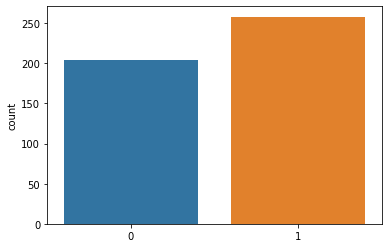

In [14]:
# Check for unblance data
sns.countplot(y_train)

## 9. Fitting a logistic regression model to the train set
<p>Essentially, predicting if a credit card application will be approved or not is a <a href="https://en.wikipedia.org/wiki/Statistical_classification">classification</a> task. According to UCI, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved. </p>
<p>This gives us a benchmark. A good machine learning model should be able to accurately predict the status of the applications with respect to these statistics.</p>
<p>Which model should we pick? A question to ask is: <em>are the features that affect the credit card approval decision process correlated with each other?</em> Although we can measure correlation, that is outside the scope of this notebook, so we'll rely on our intuition that they indeed are correlated for now. Because of this correlation, we'll take advantage of the fact that generalized linear models perform well in these cases. Let's start our machine learning modeling with a Logistic Regression model (a generalized linear model).</p>

In [15]:
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()
logreg.fit(rescaledX_test,y_train)

LogisticRegression()

Accuracy of logistic regression classifier:  1.0


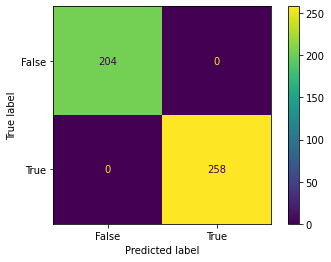

In [16]:
from sklearn import metrics

y_pred = logreg.predict(rescaledX_test)

# Get the accuracy score of logreg model
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test))

confusionmatrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionmatrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## 11. Grid searching and making the model perform better
<p>Our model was pretty good! In fact it was able to yield an accuracy score of 100%.</p>
<p>For the confusion matrix, the first element of the of the first row of the confusion matrix denotes the true negatives meaning the number of negative instances (denied applications) predicted by the model correctly. And the last element of the second row of the confusion matrix denotes the true positives meaning the number of positive instances (approved applications) predicted by the model correctly.</p>
<p>But if we hadn't got a perfect score what's to be done?. We can perform a <a href="https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/">grid search</a> of the model parameters to improve the model's ability to predict credit card approvals.</p>
<p><a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">scikit-learn's implementation of logistic regression</a> consists of different hyperparameters but we will grid search over the following two:</p>
<ul>
<li>tol</li>
<li>max_iter</li>
</ul>

In [17]:
# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
params = {
    'tol': [0.01,0.001,0.0001],
    'max_iter': [100,150,200]
}

In [18]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=params, cv=5)

# Fit grid_model to the data
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the best model and evaluate it on the test set
best_model = grid_model_result.best_estimator_
print("Accuracy of logistic regression classifier: ", best_model.score(rescaledX_test,y_test))

Best: 1.000000 using {'max_iter': 100, 'tol': 0.01}
Accuracy of logistic regression classifier:  1.0


## Using pipeline
i try to using pipeline to concise our model workflow, from impute to the end of the workflow which is predicting

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [20]:
# we load again to new dataframe
df_pipe = pd.read_csv('datasets/cc_approvals.data', header=None)

# a little bit preprocessing
df_pipe.drop(columns=[11,13], inplace=True)
df_pipe = df_pipe.replace('?', np.NaN)
df_pipe[1] = pd.to_numeric(df_pipe[1])
df_pipe.columns = [f'feature_{i}' for i in df_pipe.columns]

In [21]:
X = df_pipe.drop(columns='feature_15')
y = df_pipe['feature_15'].map({'+': 1, '-': 0}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((552, 13), (138, 13), (552,), (138,))

In [22]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ['feature_1', 'feature_2', 'feature_7', 'feature_10', 'feature_14']),
    ('categoric', categorical_pipeline, ['feature_0', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_8', 'feature_9', 'feature_12'])
])

In [23]:
# initialize the Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

In [24]:
# initialize parameter
# if you want to set parameter manually like this, you can check what parameter needed for the model, just type "pipeline.get_params()"
parameters = {
    'algo__max_iter':[100,150,200],
    'algo__tol':[0.01,0.001,0.0001]
}

model = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'algo__max_iter': 100, 'algo__tol': 0.01}
0.8731884057971014 0.8514332514332515 0.8695652173913043


Accuracy of logistic regression classifier:  0.8695652173913043


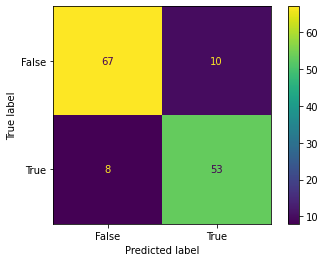

In [25]:
y_pred = model.predict(X_test)

# Get the accuracy score of logreg model
print("Accuracy of logistic regression classifier: ", model.score(X_test, y_test))

confusionmatrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionmatrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [26]:
y_score = model.predict_proba(X_test)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score)

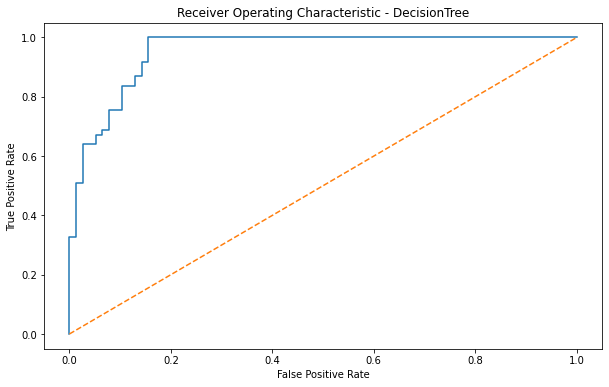

In [27]:
plt.subplots(1, figsize=(10,6))
plt.title('Receiver Operating Characteristic - LogisticReg')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Save our Model

In [30]:
import joblib

filename = 'model.pkl'
joblib.dump(model, filename)

['model.pkl']

## Summary

After we using Pipeline, our model is getting less accurate to predict than before. Maybe this is because splitting data with stratify and our feature is less in pipeline than before. But i think this is good because the purpose of we create detection model is because we want to know the failure of the model. Yet, i still learn guys, I am open to correction.